In [3]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [4]:
datacsv          = "peru_ap17/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [5]:
figures = "figures/"
if not os.path.exists(figures):
    os.makedirs(pngfolder)

In [6]:
allinfo=read_csv("allinfo_peru.csv")

In [7]:
cluster1 = np.array([i in [195, 567, 568, 569, 570, 572, 719, 720] for i in allinfo.ScenarioID])
cluster2 = np.array([i in [135,136,138,139,140,545,654] for i in allinfo.ScenarioID])
cluster3 = np.array([i in [124, 126, 131, 622, 623, 624, 642, 643, 645]+list(range(594,621))\
                     for i in allinfo.ScenarioID])
cluster4 = np.array([i in [271,272] for i in allinfo.ScenarioID])
cluster5 = np.array([i in [603,604,605] for i in allinfo.ScenarioID])

# Water levels

In [8]:
link=418
water418 = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                  columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    for RP in [5,10,25,50,100,250,500,1000]:
        col = "{}_RP{} (dm)".format(climat,RP)
        water418.loc[RP,climat]=0.1*allinfo.ix[(allinfo.ScenarioID==str(link))&\
                                       (allinfo.partial_or_full=="full"),col].values[0]

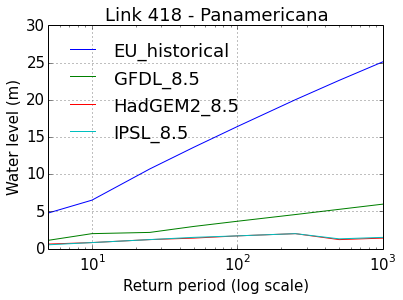

In [9]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,10))
water418.plot(logx=True,title="Link 418 - Panamericana")
plt.xlabel("Return period (log scale)")
plt.ylabel("Water level (m)")
plt.legend(frameon=False,loc=2)
plt.savefig(figures+"water_level_418.png",dpi=300)

In [169]:
link="cluster3"
water3 = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                  columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    for RP in [5,10,25,50,100,250,500,1000]:
        col = "{}_RP{} (dm)".format(climat,RP)
        water3.loc[RP,climat]=0.1*allinfo.ix[(allinfo.ScenarioID==str(link))&\
                                       (allinfo.partial_or_full=="full"),col].values[0]

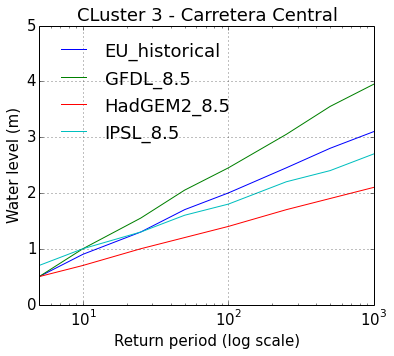

In [171]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
water3.plot(ax=ax,logx=True,title="CLuster 3 - Carretera Central")
plt.xlabel("Return period (log scale)")
plt.ylabel("Water level (m)")
ax.set_ylim([0,5])
plt.legend(frameon=False,loc=2)
plt.savefig(figures+"water_level_cluster3.png",dpi=300,bbox_inches="tight")

In [165]:
link="cluster4"
water4 = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                  columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    for RP in [5,10,25,50,100,250,500,1000]:
        col = "{}_RP{} (dm)".format(climat,RP)
        water4.loc[RP,climat]=0.1*allinfo.ix[(allinfo.ScenarioID==str(link))&\
                                       (allinfo.partial_or_full=="full"),col].values[0]

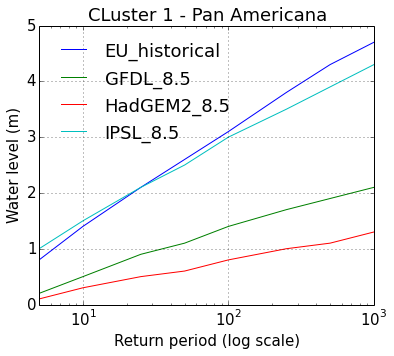

In [168]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
water4.plot(ax=ax,logx=True,title="CLuster 1 - Pan Americana")
plt.xlabel("Return period (log scale)")
plt.ylabel("Water level (m)")
ax.set_ylim([0,5])
plt.legend(frameon=False,loc=2)
plt.savefig(figures+"water_level_cluster4.png",dpi=300,bbox_inches="tight")

In [172]:
link="cluster5"
water5 = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                  columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    for RP in [5,10,25,50,100,250,500,1000]:
        col = "{}_RP{} (dm)".format(climat,RP)
        water5.loc[RP,climat]=0.1*allinfo.ix[(allinfo.ScenarioID==str(link))&\
                                       (allinfo.partial_or_full=="full"),col].values[0]

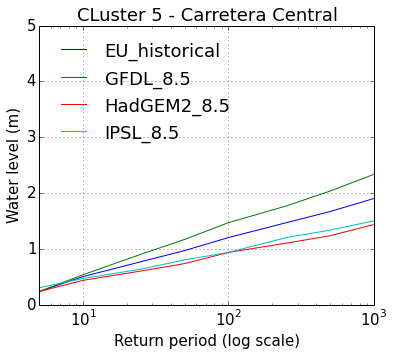

In [174]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,5))
ax=plt.subplot(111)
water5.plot(ax=ax,logx=True,title="CLuster 5 - Carretera Central")
plt.xlabel("Return period (log scale)")
plt.ylabel("Water level (m)")
ax.set_ylim([0,5])
plt.legend(frameon=False,loc=2)
plt.savefig(figures+"water_level_cluster5.png",dpi=300,bbox_inches="tight")

# Second part: calculation of expected annual losses

In [10]:
allinfo.ix[[i in [418,"cluster4","cluster3","cluster5"] for i in allinfo.ScenarioID],\
           ["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].to_csv("table1.csv")

The function below creates the step function between water level and % of traffic redirected to the second best road

In [11]:
def steps(cm,redirection):
    if redirection==0:
        if cm<15:
            percent = 0
        elif (cm>=15)&(cm<25):
            percent = 0.3
        elif (cm>=25)&(cm<35):
            percent = 0.5
        elif (cm>=35)&(cm<60):
            percent = 0.7
        else:
            percent = 1
    elif redirection==1:
        if cm<10:
            percent = 0
        elif (cm>=10)&(cm<20):
            percent = 0.4
        elif (cm>=20)&(cm<30):
            percent = 0.6
        elif (cm>=30)&(cm<45):
            percent = 0.8
        else:
            percent = 1
    elif redirection==2:
        if cm<5:
            percent = 0
        elif (cm>=5)&(cm<10):
            percent = 0.5
        elif (cm>=10)&(cm<15):
            percent = 0.7
        elif (cm>=15)&(cm<30):
            percent = 0.9
        else:
            percent = 1
    return percent

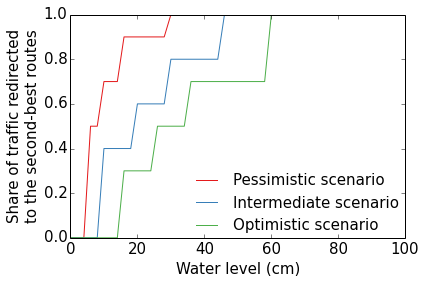

In [15]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,100,2)
plt.plot(xx,[steps(i,2) for i in xx],label="Pessimistic scenario",color="#e41a1c")
plt.plot(xx,[steps(i,1) for i in xx],label="Intermediate scenario",color="#377eb8")
plt.plot(xx,[steps(i,0) for i in xx],label="Optimistic scenario",color="#4daf4a")



plt.xlabel("Water level (cm)")
plt.ylabel("Share of traffic redirected\nto the second-best routes")
plt.legend(bbox_to_anchor=[0.52,-0.15,0.5,0.5],frameon=False,fontsize=15)
plt.savefig(figures+"traffic_scenarios.png",bbox_inches="tight",dpi=80)

The function below creates the function between water level and duration of the disruption

In [13]:
from scipy.interpolate import InterpolatedUnivariateSpline
def days(length):
    s = InterpolatedUnivariateSpline([0, 5, 30, 50, 200, 300], [0,1*length,5*length,10*length,30*length,50*length], k=1)
    return s

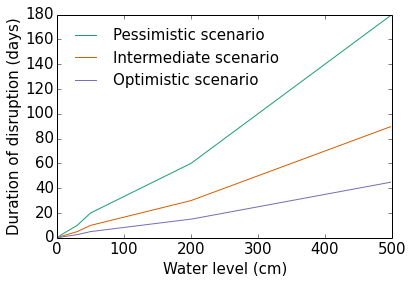

In [16]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,500,2)
s=days(2)
plt.plot(xx,[s(i,0) for i in xx],label="Pessimistic scenario",color='#1b9e77')
s=days(1)
plt.plot(xx,[s(i,0) for i in xx],label="Intermediate scenario",color='#d95f02')
s2=days(0.5)
plt.plot(xx,[s2(i,0) for i in xx],label="Optimistic scenario",color='#7570b3')

plt.xlabel("Water level (cm)")
plt.ylabel("Duration of disruption (days)")
plt.legend(bbox_to_anchor=[0.2,0.5,0.5,0.5],frameon=False,fontsize=15)
plt.savefig(figures+"duration_scenarios.png",bbox_inches="tight",dpi=80)

Here I hard coded the costs of reconstruction and rehabilitation based on the Columbian data

In [17]:
allinfo.ix[[i in [418,"cluster4"] for i in allinfo.ScenarioID],"reconstruction"]\
=970049
allinfo.ix[[i in [418,"cluster4"] for i in allinfo.ScenarioID],"rehabilitation"]\
=363289

allinfo.ix[[i in ["cluster3","cluster5"] for i in allinfo.ScenarioID],"reconstruction"]\
=1464597
allinfo.ix[[i in ["cluster3","cluster5"] for i in allinfo.ScenarioID],"rehabilitation"]\
=414823

In [18]:
allinfo.ix[[i in [418,"cluster4","cluster3","cluster5"] for i in allinfo.ScenarioID],['STATUS', 'TERRAIN', 'SURFACE1', 'COND1', 'CLASS',"reconstruction","rehabilitation"]]\
.to_csv("conditions.csv")

This function calculates expected annual losses based on losses per return period

In [19]:
def annual_losses(expected_losses,losses_col):
    '''
    Calculates expected annual losses based on losses per return period event.
    '''
    cost=expected_losses.copy()
    #keeps the last two points for extrapolation
    #sorts rows by return period
    cost.sort(columns='RP', inplace=True)
    cost.index=range(len(cost))
    cost['frequency']=1/cost['RP']
    #calculates the integral using the trapeze method
    inte=0
    for i in range(1,len(cost)):
        trapeze =(cost.loc[i-1,'frequency']-cost.loc[i,'frequency'])*(cost.loc[i,losses_col]+cost.loc[i-1,losses_col])/2
        inte += trapeze
    inte += cost.loc[len(cost)-1,losses_col]*cost.loc[len(cost)-1,'frequency']
    return inte

In [20]:
def choose_costs(allinfo,col,link):
    all_costs = Series(index=['full_disruption','partial_disruption'])
    all_costs['full_disruption'] = allinfo.ix[(allinfo.ScenarioID==link)&\
                                                 (allinfo.partial_or_full=="full"),col].values[0]
    all_costs['partial_disruption'] = allinfo.ix[(allinfo.ScenarioID==link)&\
                                                 (allinfo.partial_or_full=="partial")&\
                                                 (allinfo.part_ruc_increase==0.05),col].values[0]
    return all_costs

This function calculates the total losses for a given water level

In [21]:
def totcost(link,cm,s,all_costs,redirection,km,reconstruction,rehabilitation):
    tot = s(cm)*(all_costs["full_disruption"]*(steps(cm,redirection))+\
          all_costs["partial_disruption"]*(1-steps(cm,redirection)))
    redirect_during_work = 0.1*(1+redirection)
    if s(cm)>30:
        tot += reconstruction*km + 30*km*((1-redirect_during_work)*all_costs["partial_disruption"]+\
                                          redirect_during_work*all_costs["full_disruption"])
    elif (s(cm)<=30)&(s(cm)>10):
        tot += rehabilitation*km + 10*km*((1-redirect_during_work)*all_costs["partial_disruption"]+\
                                          redirect_during_work*all_costs["full_disruption"])
    else:
        tot += rehabilitation*km + 2*km*((1-redirect_during_work)*all_costs["partial_disruption"]+\
                                          redirect_during_work*all_costs["full_disruption"])
    return tot 

This function calculates everything

In [22]:
def summarize_costs(link,col,allinfo,climat,redirection,length):
    s = days(length)
    select = (allinfo.ScenarioID==link)&(allinfo.partial_or_full=="full")
    all_costs = choose_costs(allinfo,col,link)
    summary = DataFrame(columns=["RP","cost"])
    for rp in [5,10,25,50,100,250,500,1000]:
        cm = 10*allinfo.ix[select,climat+'_RP'+str(rp)+' (dm)'].values[0]
        km = float(allinfo.ix[select,'KM'].values[0])
        reconstruction = allinfo.ix[select,'reconstruction'].values[0]
        rehabilitation = allinfo.ix[select,'rehabilitation'].values[0]
        summary.loc[len(summary),:]=[rp,totcost(link,cm,s,all_costs,redirection,km,\
                                    reconstruction,rehabilitation)]                                      
    return summary

This function runs all scenarios

In [23]:
def run_scenarios(link,col):
    out = DataFrame(columns=['redirection','climat','length','exp_annual_losses'])

    for redirection in [0,1,2]:
        for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for length in [2,1,0.5]:
                summary = summarize_costs(link,col,allinfo,climat,redirection,length)
                out.loc[len(out),:]=[redirection,climat,length,\
                                 10**(-6)*annual_losses(summary,"cost")]
    return out

In [24]:
def run_scenarios_with_interv(link,col,interv):
    out = DataFrame(columns=['redirection','climat','length','exp_annual_losses'])

    for redirection in [0,1,2]:
        for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for length in [2,1,0.5]:
                if interv=="maintenance":
                    length = length/3
                summary = summarize_costs(link,col,allinfo,climat,redirection,length)
                new_losses  = 10**(-6)*annual_losses(summary,"cost")
                if (interv=="flood_proof")|(interv=="improvement"):
                    new_losses=0*new_losses
                out.loc[len(out),:]=[redirection,climat,length,\
                                    new_losses]
    return out

### Interventions

Here I hard code intervention costs (in million usd)

In [25]:
1464597*2

2929194

In [26]:
intervention_costs = DataFrame(index=["cluster3","cluster4","cluster5"])
intervention_costs.loc[["cluster3","cluster5"],"maintenance"]         = 10**(-6)*9167
intervention_costs.loc[["cluster3","cluster5"],"per_maintenance"]     = 10**(-6)*94499
intervention_costs.loc[["cluster3","cluster5"],"construction"]        = 10**(-6)*1464597
intervention_costs.loc[["cluster3","cluster5"],"flood_proof"]         = 100*10**(-6)*2*\
intervention_costs.loc[["cluster3","cluster5"],"construction"]
intervention_costs.loc[["cluster3","cluster5"],"improvement"]         = 10**(-6)*796878

In [27]:
intervention_costs.loc["cluster4","maintenance"]         = 10**(-6)*7503
intervention_costs.loc["cluster4","per_maintenance"]     = 10**(-6)*79944
intervention_costs.loc["cluster4","construction"]        = 10**(-6)*970049
intervention_costs.loc["cluster4","flood_proof"]         = 100*10**(-6)*2*\
intervention_costs.loc["cluster4","construction"]
intervention_costs.loc["cluster4","improvement"]         = 10**(-6)*363289

This function calculates the NPVs of the three possible interventions

In [28]:
def calc_all_npv(years,allinfo,link,intervention_costs,col,out):
    
    reduce_duration = out.exp_annual_losses-run_scenarios_with_interv(link,col,"maintenance").exp_annual_losses
    
    select = (allinfo.ScenarioID==link)&(allinfo.partial_or_full=="full")
    
    disc_fact = np.array([1/(1.05)**i for i in range(1,years+1)])
        
    disc_reduce_duration = [sum(np.array(30*[l])*disc_fact) for l in reduce_duration]
   
    maintenance = sum(np.array(years*[intervention_costs.loc[link,"maintenance"]*\
                                      allinfo.ix[select,"KM"].astype(float).values[0]])*disc_fact)+\
                  sum(np.array(years*[intervention_costs.loc[link,"per_maintenance"]/5*\
                                      allinfo.ix[select,"KM"].astype(float).values[0]])*disc_fact)
    
    npv_maintenance = disc_reduce_duration-maintenance
    
    maintenance2ndbest = np.array(years*[intervention_costs.loc[link,"maintenance"]*\
                                         allinfo.ix[select,"km_diff"].astype(float).values[0]])*disc_fact
    flood_proof = intervention_costs.loc[link,"flood_proof"]*allinfo.ix[select,"KM"].astype(float).values[0]+maintenance
    redundancy = allinfo.ix[select,"km_diff"].astype(float).values[0]*\
                 intervention_costs.loc[link,"improvement"]+\
                 sum(maintenance2ndbest)
    disc_losses = [sum(np.array(30*[l])*disc_fact) for l in out.exp_annual_losses]
    npv_flood_proof = disc_losses-flood_proof
    npv_redunduncy = disc_losses-redundancy
    return disc_losses,npv_maintenance,npv_flood_proof,npv_redunduncy

# cluster5

In [260]:
link = "cluster5"
col = "cost_with_traffic"
out5 = run_scenarios(link,col)

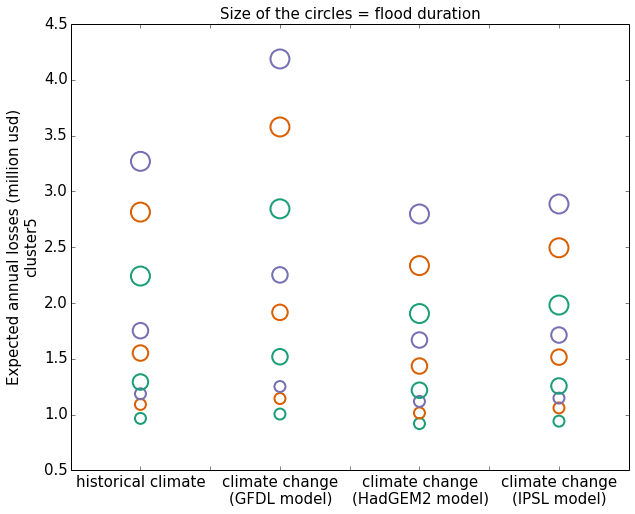

In [183]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = out5.ix[out5.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),\
                   group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = out5.ix[out5.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    
    #ax.scatter([i]*len(subout.ix[subout.redirection==2,'exp_annual_losses']),subout.ix[subout.redirection==2,'exp_annual_losses'],\
         #marker='o',s=100*subout.ix[subout.redirection==2,'length'],facecolors='none',edgecolors='#e41a1c',alpha=0.5)
    j+=1
    
#ax.scatter([j-2],[0.6*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#7570b3',linewidth='2')
#ax.annotate("pessimistic traffic",xy=(j-1.9,1*10**(2)))
#ax.scatter([j-2],[0.5*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#d95f02',linewidth='2')
#ax.annotate("intermediate traffic",xy=(j-1.9,0.9*10**(2)))
#ax.scatter([j-2],[0.4*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#1b9e77',linewidth='2')
#ax.annotate("optimistic traffic",xy=(j-1.9,0.8*10**(2)))

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

#ax.legend(bbox_to_anchor=[0.5,0.5,0.5,0.5])
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1],frameon=False)

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (million usd) \ncluster5")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)

In [268]:
years = 30
disc_losses,npv_maintenance0,npv_flood_proof0,npv_redunduncy0 = calc_all_npv(years,allinfo,"cluster5",intervention_costs,col,out5)
disc_losses,npv_maintenance1,npv_flood_proof1,npv_redunduncy1 = calc_all_npv(years,allinfo,"cluster5",intervention_costs*1.5,col,out5)
disc_losses,npv_maintenance2,npv_flood_proof2,npv_redunduncy2 = calc_all_npv(years,allinfo,"cluster5",intervention_costs*2,col,out5)

npv_maintenance = np.concatenate((npv_maintenance0,npv_maintenance1,npv_maintenance2),axis=0)
npv_flood_proof = np.concatenate((npv_flood_proof0,npv_flood_proof1,npv_flood_proof2),axis=0)
npv_redunduncy = np.concatenate((npv_redunduncy0,npv_redunduncy1,npv_redunduncy2),axis=0)

cost_factor = np.concatenate(([1]*len(npv_maintenance0),[1.5]*len(npv_maintenance0),[2]*len(npv_maintenance0)),axis=0)

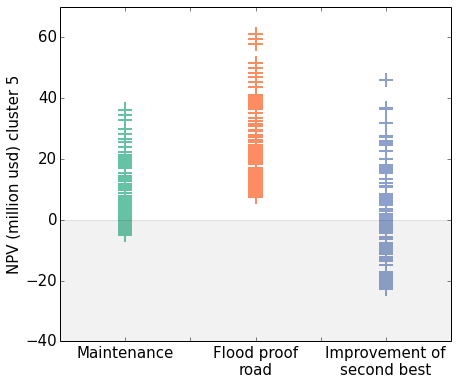

In [262]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
                 marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([2]*len(npv_redunduncy),npv_redunduncy,\
                 marker='+',s=200,facecolors='none',edgecolors='#8da0cb',linewidth='2')
    
ax.fill_between(np.arange(-1,4,1), 0, -40, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,2.5])
ax.set_ylim([-40,70])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
labelsx[3]="Flood proof\nroad"
labelsx[5]="Improvement of\nsecond best"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) cluster 5")

plt.savefig(figures+"NPV_cluster5.png",bbox_inches="tight",dpi=400)

In [263]:
aa=concat([DataFrame(npv_maintenance),DataFrame(npv_flood_proof),DataFrame(npv_redunduncy)],axis=1).max(axis=1).values
npv_flood_proof-aa

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [246]:
from lib_for_prim import *

In [248]:
out5.columns

Index(['redirection', 'climat', 'length', 'exp_annual_losses'], dtype='object')

In [296]:
experiments0=out5.drop(["exp_annual_losses","climat"],axis=1).copy()
experiments = concat([concat([experiments0,experiments0,experiments0],axis=0).reset_index().drop("index",axis=1),DataFrame(cost_factor,columns=["cost"])],axis=1)
outcomes=DataFrame(npv_maintenance,columns=["npv"])
outcomes['neg']=0+(outcomes<0)

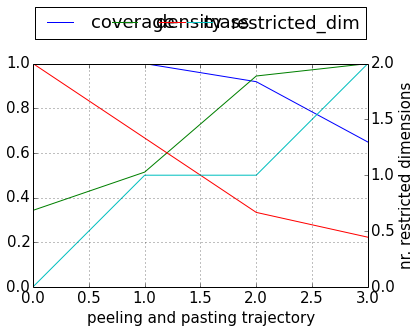

In [297]:
forprim=format_data(outcomes,experiments,"neg")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [298]:
box.inspect(2)

coverage    0.918919
density     0.944444
mass        0.333333
mean        0.944444
res dim     1.000000
Name: 2, dtype: float64

       box 2                    
         min   max     qp values
length   0.5  0.75  4.269591e-14



# cluster 3

In [29]:
link = "cluster3"
col = "cost_with_traffic"
out3 = run_scenarios(link,col)

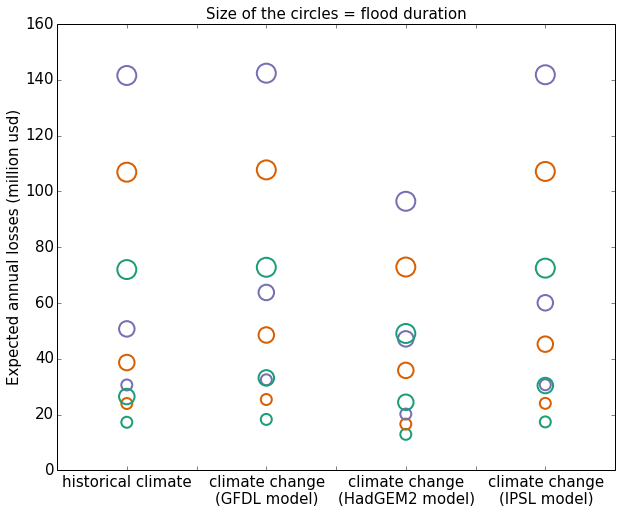

In [30]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = out3.ix[out3.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),\
                   group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = out3.ix[out3.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    
    #ax.scatter([i]*len(subout.ix[subout.redirection==2,'exp_annual_losses']),subout.ix[subout.redirection==2,'exp_annual_losses'],\
         #marker='o',s=100*subout.ix[subout.redirection==2,'length'],facecolors='none',edgecolors='#e41a1c',alpha=0.5)
    j+=1
    
#ax.scatter([j-2],[0.6*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#7570b3',linewidth='2')
#ax.annotate("pessimistic traffic",xy=(j-1.9,1*10**(2)))
#ax.scatter([j-2],[0.5*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#d95f02',linewidth='2')
#ax.annotate("intermediate traffic",xy=(j-1.9,0.9*10**(2)))
#ax.scatter([j-2],[0.4*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#1b9e77',linewidth='2')
#ax.annotate("optimistic traffic",xy=(j-1.9,0.8*10**(2)))

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

#ax.legend(bbox_to_anchor=[0.5,0.5,0.5,0.5])
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1],frameon=False)

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (million usd)")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)

I calculate the NPVs with different cost increase factors

In [31]:
years = 30
disc_losses,npv_maintenance0,npv_flood_proof0,npv_redunduncy0 = calc_all_npv(years,allinfo,"cluster3",intervention_costs,col,out3)
disc_losses,npv_maintenance1,npv_flood_proof1,npv_redunduncy1 = calc_all_npv(years,allinfo,"cluster3",intervention_costs*1.5,col,out3)
disc_losses,npv_maintenance2,npv_flood_proof2,npv_redunduncy2 = calc_all_npv(years,allinfo,"cluster3",intervention_costs*2,col,out3)

npv_maintenance = np.concatenate((npv_maintenance0,npv_maintenance1,npv_maintenance2),axis=0)
npv_flood_proof = np.concatenate((npv_flood_proof0,npv_flood_proof1,npv_flood_proof2),axis=0)
npv_redunduncy = np.concatenate((npv_redunduncy0,npv_redunduncy1,npv_redunduncy2),axis=0)

In [32]:
aa=concat([DataFrame(npv_maintenance),DataFrame(npv_redunduncy)],axis=1).max(axis=1).values
print(min(npv_redunduncy-aa))
print(min(npv_maintenance-aa))

0.0
-733.911658955


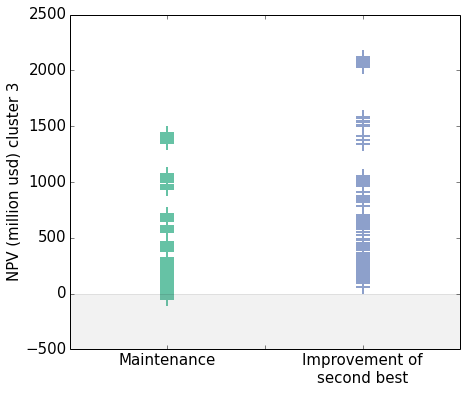

In [33]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

#ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
                 #marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(npv_redunduncy),npv_redunduncy,\
                 marker='+',s=200,facecolors='none',edgecolors='#8da0cb',linewidth='2')
    
ax.fill_between(np.arange(-1,4,1), 0, -500, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-500,2500])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
#labelsx[3]="Flood proof\nroad"
labelsx[3]="Improvement of\nsecond best"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) cluster 3")

plt.savefig(figures+"NPV_cluster3.png",bbox_inches="tight",dpi=80)

Here I calculate regret

In [293]:
print(-min(npv_flood_proof)/max(disc_losses))
print(-min(npv_maintenance)/max(disc_losses))
print(-min(npv_redunduncy)/max(disc_losses))

-0.151928077858
-0.106692060371
-0.11886897469


In [294]:
print(-min(npv_flood_proof))
print(-min(npv_maintenance))
print(-min(npv_redunduncy))

-319.856779278
-224.620618427
-250.256884286


## Analysis for cluster4

In [34]:
link = "cluster4"
col = "cost_with_traffic"
out4 = run_scenarios(link,col)

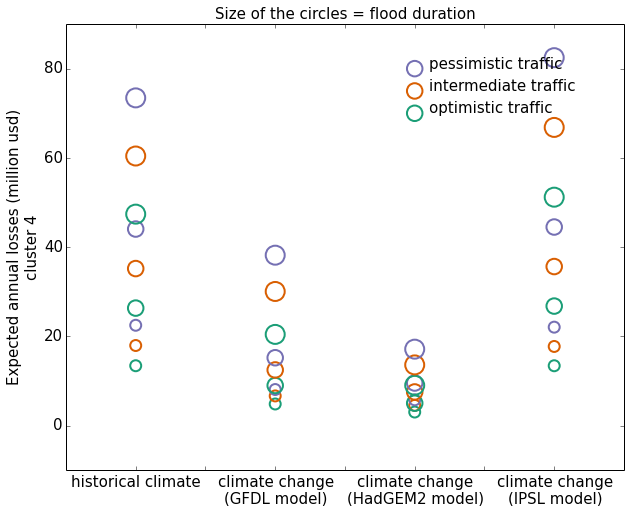

In [35]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = out4.ix[out4.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = out4.ix[out4.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    
    #ax.scatter([i]*len(subout.ix[subout.redirection==2,'exp_annual_losses']),subout.ix[subout.redirection==2,'exp_annual_losses'],\
         #marker='o',s=100*subout.ix[subout.redirection==2,'length'],facecolors='none',edgecolors='#e41a1c',alpha=0.5)
    j+=1
    
ax.scatter([j-2],[0.8*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#7570b3',linewidth='2')
ax.annotate("pessimistic traffic",xy=(j-1.9,0.8*10**(2)))
ax.scatter([j-2],[0.75*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#d95f02',linewidth='2')
ax.annotate("intermediate traffic",xy=(j-1.9,0.75*10**(2)))
ax.scatter([j-2],[0.7*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#1b9e77',linewidth='2')
ax.annotate("optimistic traffic",xy=(j-1.9,0.7*10**(2)))

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

#ax.legend(bbox_to_anchor=[0.5,0.5,0.5,0.5])
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1],frameon=False)

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (million usd) \ncluster 4")

plt.savefig(figures+"results_cluster4.png",bbox_inches="tight",dpi=400)

In [36]:
years = 30
disc_losses,npv_maintenance0,npv_flood_proof0,npv_redunduncy0 = calc_all_npv(years,allinfo,"cluster4",intervention_costs,col,out4)
disc_losses,npv_maintenance1,npv_flood_proof1,npv_redunduncy1 = calc_all_npv(years,allinfo,"cluster4",intervention_costs*1.5,col,out4)
disc_losses,npv_maintenance2,npv_flood_proof2,npv_redunduncy2 = calc_all_npv(years,allinfo,"cluster4",intervention_costs*2,col,out4)

npv_maintenance = np.concatenate((npv_maintenance0,npv_maintenance1,npv_maintenance2),axis=0)
npv_flood_proof = np.concatenate((npv_flood_proof0,npv_flood_proof1,npv_flood_proof2),axis=0)
npv_redunduncy = np.concatenate((npv_redunduncy0,npv_redunduncy1,npv_redunduncy2),axis=0)

In [37]:
aa=concat([DataFrame(npv_maintenance),DataFrame(npv_redunduncy)],axis=1).max(axis=1).values
print(min(npv_redunduncy-aa))
print(min(npv_maintenance-aa))

-233.931741612
-327.623423925


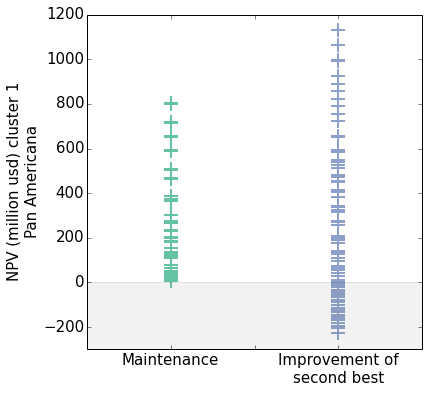

In [237]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

#ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
 #                marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(npv_redunduncy),npv_redunduncy,\
                 marker='+',s=200,facecolors='none',edgecolors='#8da0cb',linewidth='2')
    
ax.fill_between(np.arange(-1,4,1), 0, -300, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-300,1200])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
#labelsx[3]="Flood proof road"
labelsx[3]="Improvement of\nsecond best"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) cluster 1\nPan Americana")

plt.savefig(figures+"NPV_cluster4.png",bbox_inches="tight",dpi=400)

In [304]:
experiments0=out4.drop(["exp_annual_losses","climat"],axis=1).copy()
experiments = concat([concat([experiments0,experiments0,experiments0],axis=0).reset_index().drop("index",axis=1),DataFrame(cost_factor,columns=["cost"])],axis=1)
outcomes=DataFrame(npv_redunduncy,columns=["npv"])
outcomes['neg']=0+(outcomes<0)

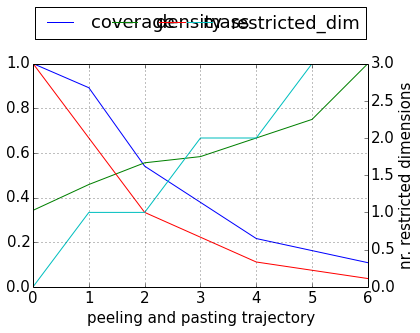

In [305]:
forprim=format_data(outcomes,experiments,"neg")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [306]:
box.inspect(2)

coverage    0.540541
density     0.555556
mass        0.333333
mean        0.555556
res dim     1.000000
Name: 2, dtype: float64

       box 2                
         min   max qp values
length   0.5  0.75  0.007058



In [ ]:
print(-min(npv_flood_proof)/max(disc_losses))
print(-min(npv_maintenance)/max(disc_losses))
print(-min(npv_redunduncy)/max(disc_losses))

In [ ]:
print(-min(npv_flood_proof))
print(-min(npv_maintenance))
print(-min(npv_redunduncy))

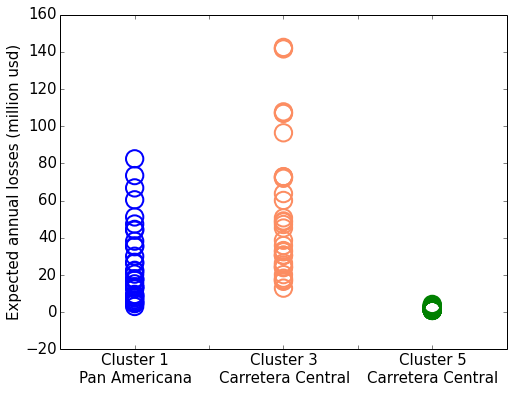

In [207]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([1]*len(out3.exp_annual_losses),out3.exp_annual_losses,\
                 marker='o',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([0]*len(out4.exp_annual_losses),out4.exp_annual_losses,\
                 marker='o',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([2]*len(out5.exp_annual_losses),out5.exp_annual_losses,\
                 marker='o',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.set_xlim([-0.5,2.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Cluster 1\nPan Americana"
labelsx[3]="Cluster 3\nCarretera Central"
labelsx[5]="Cluster 5\nCarretera Central"

ax.set_xticklabels(labelsx)

plt.ylabel("Expected annual losses (million usd)")

plt.savefig(figures+"EL.png",bbox_inches="tight",dpi=400)

In [79]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [80]:
out3.columns

Index(['redirection', 'climat', 'length', 'exp_annual_losses'], dtype='object')

In [98]:
olsmodel=ols(formula,data=out3.drop("climat",axis=1).astype(float)).fit()

In [100]:
table=anova_lm(olsmodel)

In [101]:
table

,df,sum_sq,mean_sq,F,PR(>F)
redirection,1,25563.864497,25563.864497,43.165417,1.820277e-07
length,1,40263.209965,40263.209965,67.985741,1.602009e-09
Residual,33,19543.597189,592.230218,NaN,NaN


In [103]:
olsmodel=ols(formula,data=out5.drop("climat",axis=1).astype(float)).fit()
table5=anova_lm(olsmodel)

In [104]:
table5

,df,sum_sq,mean_sq,F,PR(>F)
redirection,1,18.099124,18.099124,53.836648,2.008027e-08
length,1,99.951853,99.951853,297.311216,4.509491e-18
Residual,33,11.094136,0.336186,NaN,NaN


# link 418

In [ ]:
allinfo.ix[allinfo.ScenarioID=='418',["cost_with_traffic","partial_or_full","part_ruc_increase"]]

In [ ]:
allinfo.ix[(allinfo.ScenarioID=='418')&(allinfo.part_ruc_increase==0.05),"cost_with_traffic"]=0

In [ ]:
link = '418'
col = "cost_with_traffic"
out418 = run_scenarios(link,col)

In [ ]:
out418